In [1]:
import os
import tqdm
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from darts import TimeSeries

In [2]:
# 设置绘图风格
plt.rcParams["font.sans-serif"] = ["SimHei"]
matplotlib.rcParams["axes.unicode_minus"] = False
# 编码格式为gb18030
day_data = pd.read_table("./HSI_日线数据.txt", encoding="gb18030", skiprows=1)
day_data = day_data.iloc[:-1]
day_data.columns = day_data.columns.str.strip()

In [3]:
series = TimeSeries.from_dataframe(day_data, value_cols=["收盘"], time_col="日期", freq="D")
series_df = series.pd_dataframe()
series_df = series_df.interpolate(method="linear")
series = TimeSeries.from_dataframe(series_df)

## Calculate KDJ

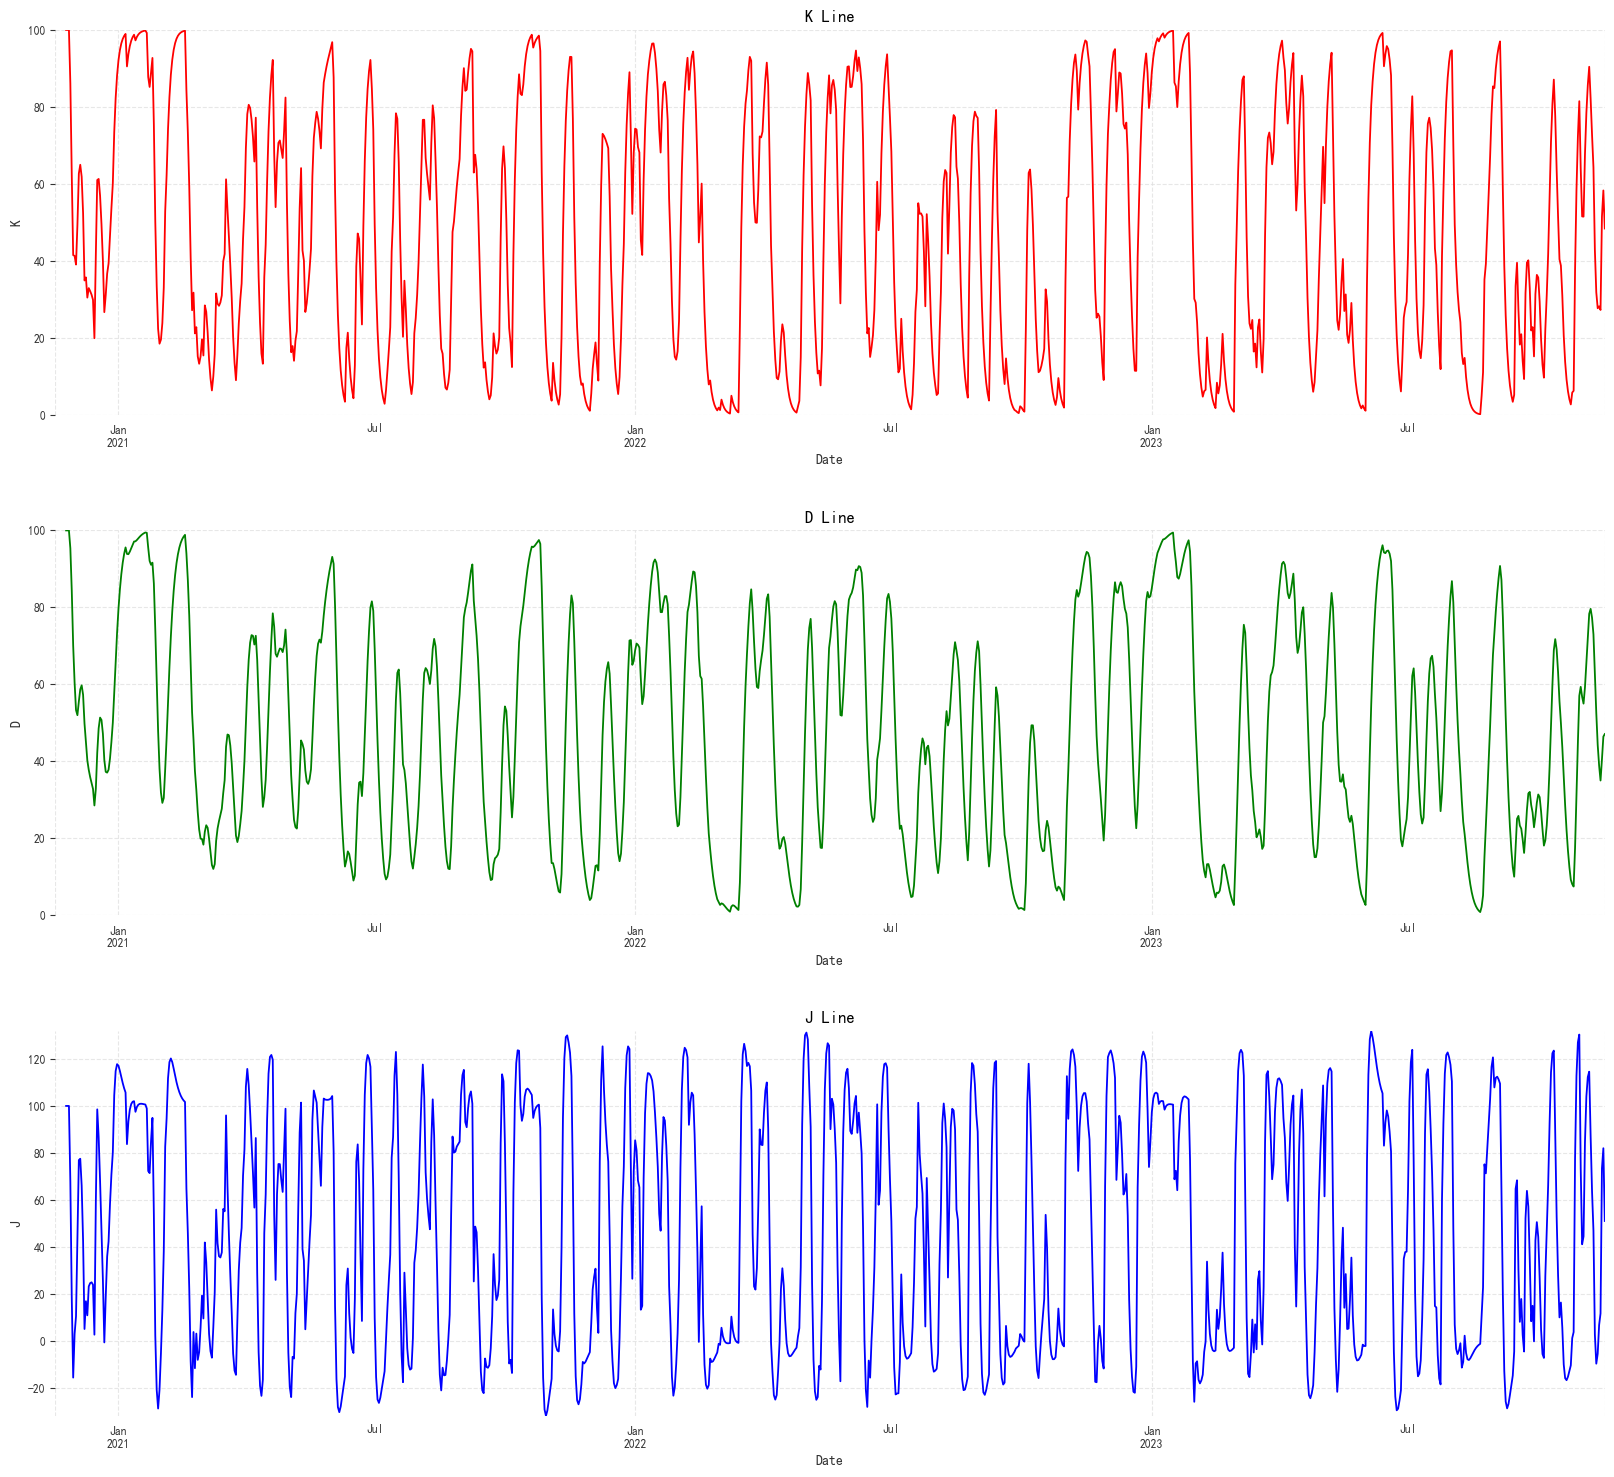

In [4]:
close = series_df["收盘"]
KDJ_part = pd.date_range(start="2020-11-17", end="2023-11-17", freq="D")
close = close.loc[KDJ_part]
# 计算 RSV
low_list = pd.Series.rolling(close, window=9).min()
high_list = pd.Series.rolling(close, window=9).max()
rsv = (close - low_list) / (high_list - low_list) * 100

K = pd.Series.ewm(rsv, adjust=False, alpha=1 / 3).mean()
D = pd.Series.ewm(K, adjust=False, alpha=1 / 3).mean()
J = 3 * K - 2 * D

series_df["K"] = K
series_df["D"] = D
series_df["J"] = J

fig, axes = plt.subplots(3, 1, figsize=(20, 18))
fig.subplots_adjust(hspace=0.3)

series_df["K"].plot(ax=axes[0], color="red", label="K")
series_df["D"].plot(ax=axes[1], color="green", label="D")
series_df["J"].plot(ax=axes[2], color="blue", label="J")

for ax in axes:
    ax.set_xlabel("Date")
    ax.grid(True, linestyle="--", alpha=0.7)

axes[0].set_ylabel("K")
axes[1].set_ylabel("D")
axes[2].set_ylabel("J")
axes[0].set_title("K Line")
axes[1].set_title("D Line")
axes[2].set_title("J Line")

axes[0].set_xlim(close.index[0], close.index[-1])
axes[1].set_xlim(close.index[0], close.index[-1])
axes[2].set_xlim(close.index[0], close.index[-1])

axes[0].set_ylim(min(series_df["K"].min(), 0), max(series_df["K"].max(), 0))
axes[1].set_ylim(min(series_df["D"].min(), 0), max(series_df["D"].max(), 0))
axes[2].set_ylim(min(series_df["J"].min(), 0), max(series_df["J"].max(), 0))

plt.show()

## Calculate MACD

In [5]:
short_term_window = 12
long_term_window = 26

short_term_ema = series_df["收盘"].rolling(window=short_term_window, min_periods=1).mean()
long_term_ema = series_df["收盘"].rolling(window=long_term_window, min_periods=1).mean()


macd_line = short_term_ema - long_term_ema
signal_line = macd_line.rolling(window=9, min_periods=1).mean()

macd_baseline = macd_line - signal_line
# 将macd_baseline标准化
std_macd_baseline = (macd_baseline - macd_baseline.mean()) / macd_baseline.std()
std_macd_baseline = macd_baseline / macd_baseline.abs().max()

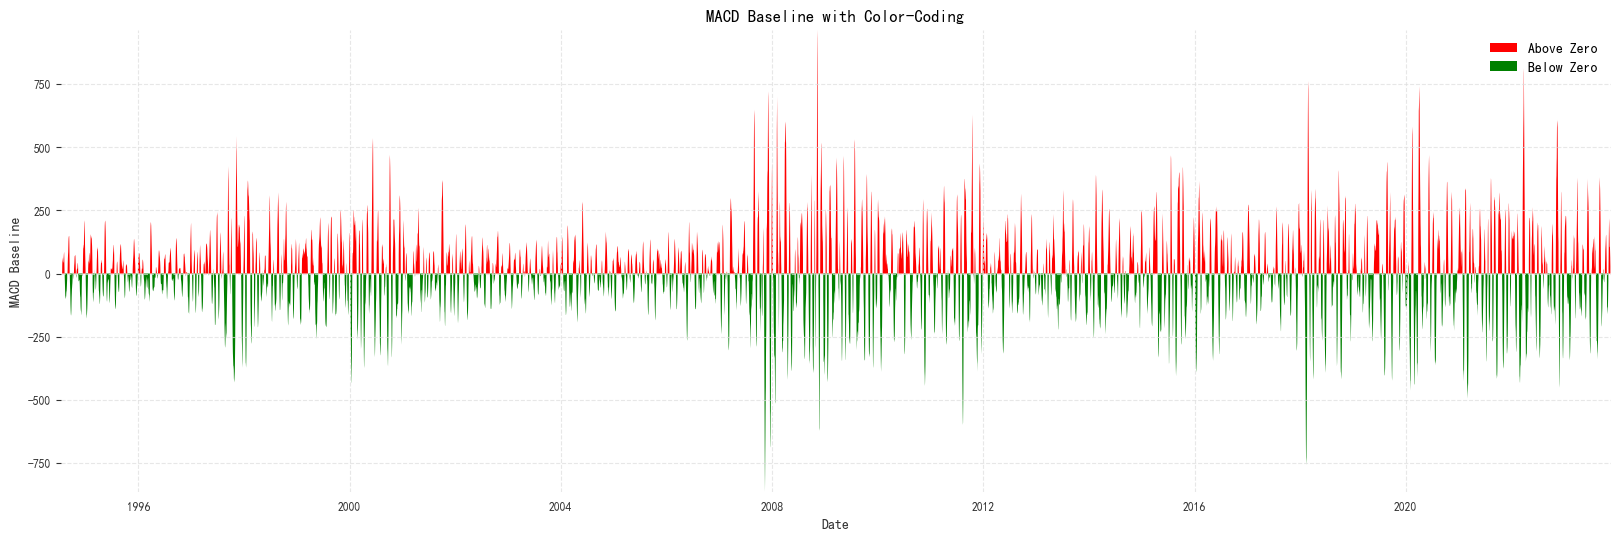

In [6]:
fig, ax = plt.subplots(figsize=(20, 6))

# 美化填充区域
ax.fill_between(
    macd_baseline.index,
    macd_baseline,
    where=(macd_baseline >= 0),
    facecolor="red",
    label="Above Zero",
)
ax.fill_between(
    macd_baseline.index,
    macd_baseline,
    where=(macd_baseline < 0),
    facecolor="green",
    label="Below Zero",
)

# 添加标题和标签
plt.title("MACD Baseline with Color-Coding")
plt.xlabel("Date")
plt.ylabel("MACD Baseline")

# 显示图例
plt.legend()

# 设置坐标轴范围
ax.set_xlim(macd_baseline.index[0], macd_baseline.index[-1])
ax.set_ylim(min(macd_baseline.min(), 0), max(macd_baseline.max(), 0))

# 添加网格线
ax.grid(True, linestyle="--", alpha=0.7)

# 显示图形
plt.show()

## Calculate RSI

In [7]:
def calculate_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    average_gain = up.rolling(window=window).mean()
    average_loss = abs(down.rolling(window=window).mean())

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


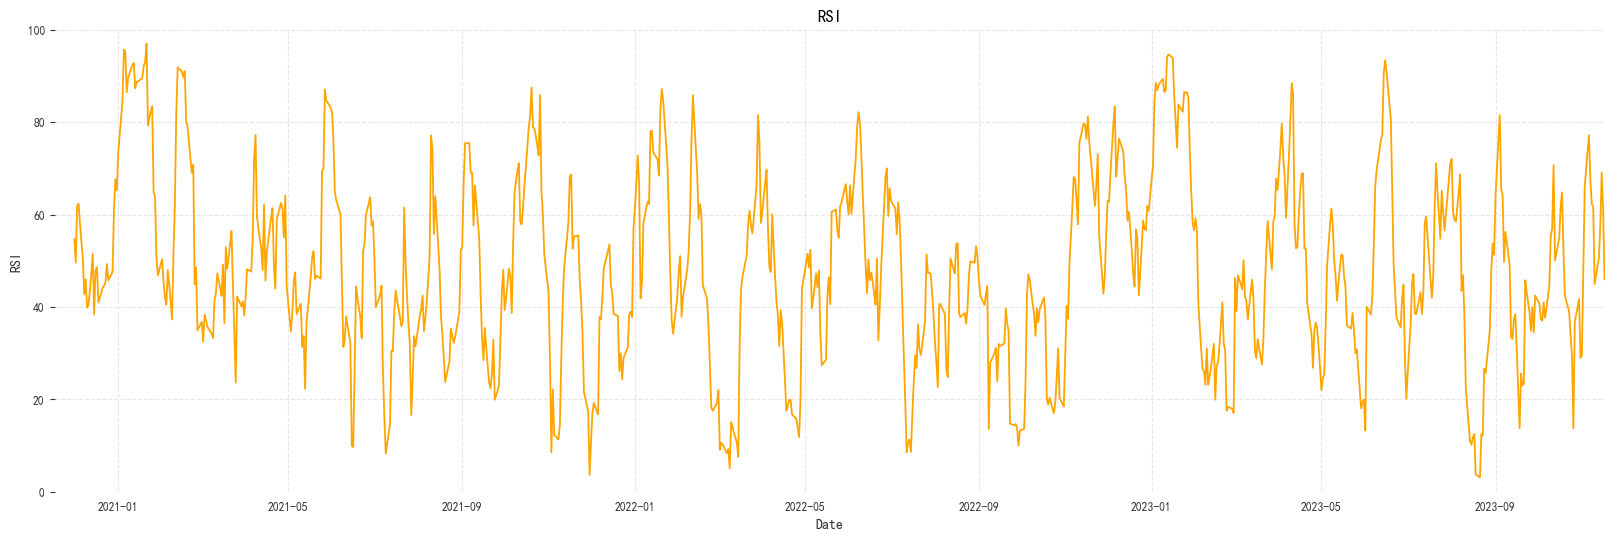

In [8]:
rsi = calculate_rsi(close, 14)
plt.figure(figsize=(20, 6))
plt.ylabel("RSI")
plt.xlabel("Date")
plt.title("RSI")
plt.xlim(rsi.index[0], rsi.index[-1])
plt.ylim(0, 100)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.plot(rsi, color="orange", label="RSI")

## Calculate Investment Ratio

In [9]:
def calculate_investment_ratio(rate_of_return):
    return 10 * rate_of_return

In [10]:
def adjust_ratios(rsi, macd_baseline, k, d, j):
    if rsi > 60 and macd_baseline > 80:
        # RSI 高，可能超买，增加卖出比例，减少买入比例
        selling_ratios = [0.6, 0.8, 1, 1]
        buying_ratios = [0.2, 0.4, 0.6, 0.8]

    elif rsi < 30 and macd_baseline < -80:
        # RSI 低，可能超卖，减少卖出比例，增加买入比例
        selling_ratios = [0.2, 0.4, 0.6, 0.8]
        buying_ratios = [0.8, 0.9, 1, 1]

    elif j > 100:
        # J线值大于100，可能预示市场将下跌，增加卖出比例，减少买入比例
        selling_ratios = [0.6, 0.8, 1, 1]
        buying_ratios = [0.2, 0.4, 0.6, 0.8]

    elif j < 0:
        # J线值小于0，可能预示市场将上涨，减少卖出比例，增加买入比例
        selling_ratios = [0.2, 0.4, 0.6, 0.8]
        buying_ratios = [0.8, 0.9, 1, 1]

    else:
        # RSI 和 KDJ 正常，使用默认比例
        selling_ratios = [0.2, 0.4, 0.8, 1]
        buying_ratios = [0.2, 0.4, 0.8, 1]

    return selling_ratios, buying_ratios

## Invest

In [11]:
def use_csv_to_quant_invest(
    series,
    duration_start,
    duration_end,
    k,
    d,
    j,
    rsi,
    macd_baseline,
    interval_num=3,
    fee_ratio=0.0025,
    csv_path="./prophet_rate_of_return.csv",
):
    initial_capital = 1000000
    initial_stock = 0
    daily_wealth = []
    current_stocks = []
    daily_rate_of_return = []

    # current_wealth为当前的资金+当前的股票价值
    current_wealth = initial_capital

    # current_capital为当前资金
    current_capital = initial_capital
    current_stock = initial_stock
    daily_rate_of_return_df = pd.read_csv(csv_path, index_col=0)

    # 剔除3std之外的数据
    daily_rate_of_std = daily_rate_of_return_df["收益率"].std()
    daily_rate_of_return_df_without_3std = daily_rate_of_return_df[
        (
            daily_rate_of_return_df["收益率"]
            < daily_rate_of_return_df["收益率"].mean() + 3 * daily_rate_of_std
        )
        & (
            daily_rate_of_return_df["收益率"]
            > daily_rate_of_return_df["收益率"].mean() - 3 * daily_rate_of_std
        )
    ]

    max_rate_of_return = daily_rate_of_return_df_without_3std["收益率"].max()
    min_rate_of_return = daily_rate_of_return_df_without_3std["收益率"].min()
    daily_rate_of_return_df.index = pd.to_datetime(daily_rate_of_return_df.index)

    # 划分区间
    greater_one = max(abs(min_rate_of_return), max_rate_of_return)
    interval = greater_one / interval_num

    # 将RSI从Series转换为dataframe
    rsi_df = pd.DataFrame(rsi)
    rsi_df.columns = ["RSI"]

    # 将macd转换成dataframe
    macd_baseline_df = pd.DataFrame(macd_baseline)
    macd_baseline_df.columns = ["MACD"]

    # 将KDJ转换成dataframe
    k_df = pd.DataFrame(k)
    j_df = pd.DataFrame(j)
    d_df = pd.DataFrame(d)
    k_df.columns = ["K"]
    d_df.columns = ["D"]
    j_df.columns = ["J"]

    # # 输出总区间以及各个区间的临界值作为测试
    # print("区间为: ", interval)
    # print("最大值为: ", max_rate_of_return)
    # print("最小值为: ", min_rate_of_return)
    # print("第一区间临界值为: ", interval)
    # print("第二区间临界值为: ", 2 * interval)
    # print("第三区间临界值为: ", 3 * interval)
    # print(daily_rate_of_return_df_without_3std.max())

    for day in tqdm.tqdm_notebook(
        pd.date_range(duration_start, duration_end, freq="D"),
        desc="Quant Investing Progress",
    ):
        today_stock_price = series.pd_dataframe().loc[day]["收盘"]
        today_rate_of_return = daily_rate_of_return_df.loc[day]["收益率"]
        daily_rate_of_return.append(today_rate_of_return)
        today_rsi = rsi_df.loc[day]["RSI"]
        today_macd_baseline = macd_baseline_df.loc[day]["MACD"]
        today_k = k_df.loc[day]["K"]
        today_d = d_df.loc[day]["D"]
        today_j = j_df.loc[day]["J"]

        fee = 0

        selling_ratios, buying_ratios = adjust_ratios(
            today_rsi, today_macd_baseline, today_k, today_d, today_j
        )

        # selling_ratios = [1, 1, 1, 1]
        # buying_ratios = [1, 1, 1, 1]

        # 若持股
        if current_stock > 0 and today_rate_of_return <= 0:
            # 用整除计算所在区间，并获得对应的卖出比例
            selling_ratio = selling_ratios[
                min(int(abs(today_rate_of_return) // interval), interval_num - 1)
            ]
            selling_stock_num = np.round(current_stock * selling_ratio)
            current_capital += selling_stock_num * today_stock_price
            fee = selling_stock_num * today_stock_price * fee_ratio
            current_stock -= selling_stock_num

        # 收益率为正
        elif today_rate_of_return > 0.15 * greater_one:
            # 0.15 对应第三幅截图

            # 用于买入的资金
            buying_ratio = buying_ratios[
                min(int(today_rate_of_return // interval), interval_num - 1)
            ]
            buying_capital = current_capital * buying_ratio
            fee = buying_capital * fee_ratio
            buying_stock_num = buying_capital // today_stock_price
            current_capital -= buying_stock_num * today_stock_price
            current_stock += buying_stock_num

        # 计算当前的总资产
        current_wealth = current_capital + current_stock * today_stock_price - fee
        daily_wealth.append(current_wealth)
        current_stocks.append(current_stock)

    # 计算最终收益率
    final_return = (current_wealth - initial_capital) / initial_capital

    return daily_wealth, final_return, current_stocks, daily_rate_of_return

In [12]:
def use_csv_to_quant_invest_show_hand(
    series,
    duration_start,
    duration_end,
    k,
    d,
    j,
    rsi,
    macd_baseline,
    interval_num=3,
    fee_ratio=0.0025,
    csv_path="./prophet_rate_of_return.csv",
):
    initial_capital = 1000000
    initial_stock = 0
    daily_wealth = []
    current_stocks = []
    daily_rate_of_return = []

    # current_wealth为当前的资金+当前的股票价值
    current_wealth = initial_capital

    # current_capital为当前资金
    current_capital = initial_capital
    current_stock = initial_stock
    daily_rate_of_return_df = pd.read_csv(csv_path, index_col=0)

    # 剔除3std之外的数据
    daily_rate_of_std = daily_rate_of_return_df["收益率"].std()
    daily_rate_of_return_df_without_3std = daily_rate_of_return_df[
        (
            daily_rate_of_return_df["收益率"]
            < daily_rate_of_return_df["收益率"].mean() + 3 * daily_rate_of_std
        )
        & (
            daily_rate_of_return_df["收益率"]
            > daily_rate_of_return_df["收益率"].mean() - 3 * daily_rate_of_std
        )
    ]

    max_rate_of_return = daily_rate_of_return_df_without_3std["收益率"].max()
    min_rate_of_return = daily_rate_of_return_df_without_3std["收益率"].min()
    daily_rate_of_return_df.index = pd.to_datetime(daily_rate_of_return_df.index)

    # 划分区间
    greater_one = max(abs(min_rate_of_return), max_rate_of_return)
    interval = greater_one / interval_num

    # 将RSI从Series转换为dataframe
    rsi_df = pd.DataFrame(rsi)
    rsi_df.columns = ["RSI"]

    # 将macd转换成dataframe
    macd_baseline_df = pd.DataFrame(macd_baseline)
    macd_baseline_df.columns = ["MACD"]

    # 将KDJ转换成dataframe
    k_df = pd.DataFrame(k)
    j_df = pd.DataFrame(j)
    d_df = pd.DataFrame(d)
    k_df.columns = ["K"]
    d_df.columns = ["D"]
    j_df.columns = ["J"]

    # # 输出总区间以及各个区间的临界值作为测试
    # print("区间为: ", interval)
    # print("最大值为: ", max_rate_of_return)
    # print("最小值为: ", min_rate_of_return)
    # print("第一区间临界值为: ", interval)
    # print("第二区间临界值为: ", 2 * interval)
    # print("第三区间临界值为: ", 3 * interval)
    # print(daily_rate_of_return_df_without_3std.max())

    for day in tqdm.tqdm_notebook(
        pd.date_range(duration_start, duration_end, freq="D"),
        desc="Quant Investing Progress",
    ):
        today_stock_price = series.pd_dataframe().loc[day]["收盘"]
        today_rate_of_return = daily_rate_of_return_df.loc[day]["收益率"]
        daily_rate_of_return.append(today_rate_of_return)
        today_rsi = rsi_df.loc[day]["RSI"]
        today_macd_baseline = macd_baseline_df.loc[day]["MACD"]
        today_k = k_df.loc[day]["K"]
        today_d = d_df.loc[day]["D"]
        today_j = j_df.loc[day]["J"]

        fee = 0

        selling_ratios, buying_ratios = adjust_ratios(
            today_rsi, today_macd_baseline, today_k, today_d, today_j
        )

        # 直接梭哈，不使用RSI和MACD进行调整
        selling_ratios = [1, 1, 1, 1]
        buying_ratios = [1, 1, 1, 1]

        # 若持股
        if current_stock > 0 and today_rate_of_return <= 0:
            # 用整除计算所在区间，并获得对应的卖出比例
            selling_ratio = selling_ratios[
                min(int(abs(today_rate_of_return) // interval), interval_num - 1)
            ]
            selling_stock_num = np.round(current_stock * selling_ratio)
            current_capital += selling_stock_num * today_stock_price
            fee = selling_stock_num * today_stock_price * fee_ratio
            current_stock -= selling_stock_num

        # 收益率为正
        elif today_rate_of_return > 0.00001:
            # 0.15 对应第三幅截图

            # 用于买入的资金
            buying_ratio = buying_ratios[
                min(int(today_rate_of_return // interval), interval_num - 1)
            ]
            buying_capital = current_capital * buying_ratio
            fee = buying_capital * fee_ratio
            buying_stock_num = buying_capital // today_stock_price
            current_capital -= buying_stock_num * today_stock_price
            current_stock += buying_stock_num

        # 计算当前的总资产
        current_wealth = current_capital + current_stock * today_stock_price - fee
        daily_wealth.append(current_wealth)
        current_stocks.append(current_stock)

    # 计算最终收益率
    final_return = (current_wealth - initial_capital) / initial_capital

    return daily_wealth, final_return, current_stocks, daily_rate_of_return

## Calculate Max Drawdown


In [13]:
# 计算最大回撤
def calculate_max_drawdown(wealth_curve):
    max_drawdown = 0
    for i in range(len(wealth_curve)):
        for j in range(i + 1, len(wealth_curve)):
            drawdown = (wealth_curve[i] - wealth_curve[j]) / wealth_curve[i]
            if drawdown > max_drawdown:
                max_drawdown = drawdown
    return max_drawdown

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

ExponentialSmoothing      的最终收益率为: -0.49%
Prophet                   的最终收益率为: 23.49%
StatsForecastAutoARIMA    的最终收益率为: 15.15%
Dlinear                   的最终收益率为: 0.63%
TiDE                      的最终收益率为: -14.09%
TCN                       的最终收益率为: -6.90%


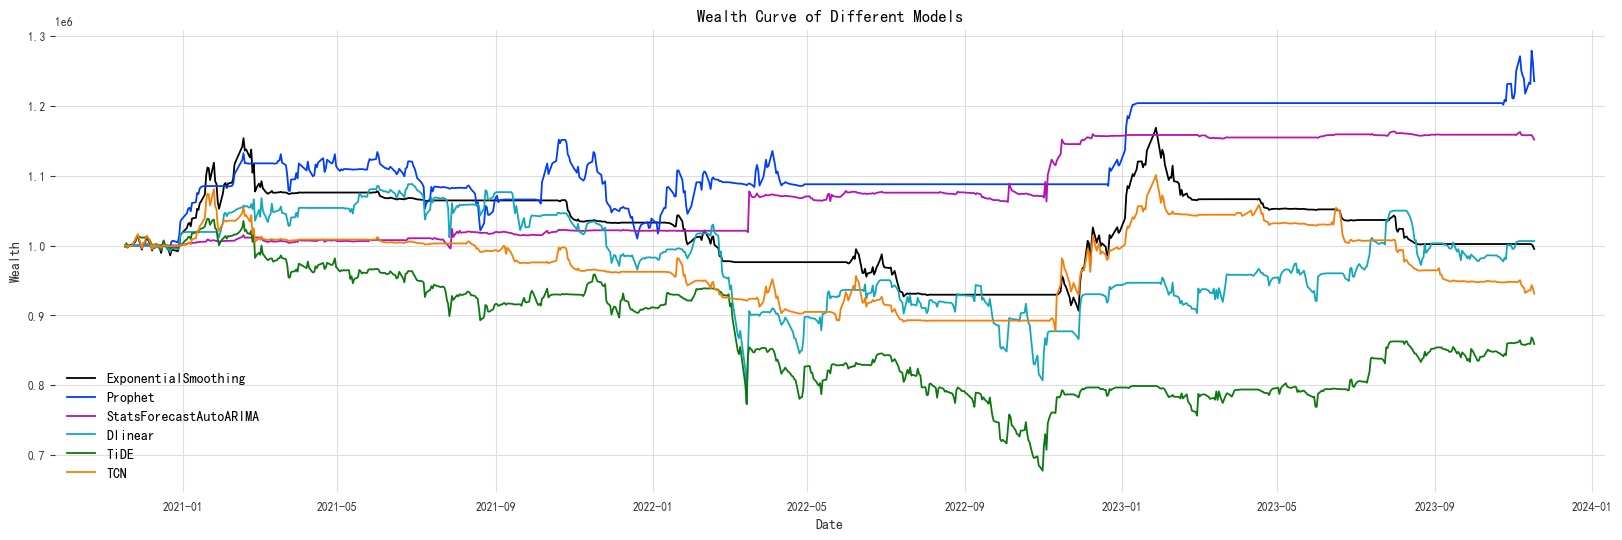

ExponentialSmoothing      的最大回撤为: 21.38%
Prophet                   的最大回撤为: 12.29%
StatsForecastAutoARIMA    的最大回撤为: 2.58%
Dlinear                   的最大回撤为: 28.63%
TiDE                      的最大回撤为: 34.71%
TCN                       的最大回撤为: 18.83%


In [14]:
# CSV文件的路径列表
csv_paths = [
    "./ExponentialSmoothing_rate_of_return.csv",
    "./prophet_rate_of_return.csv",
    "./StatsForecastAutoARIMA_rate_of_return.csv",
    "./Dlinear_rate_of_return_first.csv",
    "./TiDE_rate_of_return.csv",
    "./TCN_rate_of_return.csv",
]

# 绘图lable列表
lables = [
    "ExponentialSmoothing",
    "Prophet",
    "StatsForecastAutoARIMA",
    "Dlinear",
    "TiDE",
    "TCN",
]

results = []

# 遍历CSV文件的路径列表
for csv_path in csv_paths:
    result = use_csv_to_quant_invest(
        series=series,
        duration_start="2020-11-17",
        duration_end="2023-11-17",
        rsi=rsi,
        k=K,
        d=D,
        j=J,
        macd_baseline=macd_baseline,
        interval_num=3,
        csv_path=csv_path,
    )
    results.append(result)

plt.figure(figsize=(20, 6))
plt_range = pd.date_range("2020-11-17", "2023-11-17", freq="D")

for i, result in enumerate(results):
    plt.plot(plt_range, result[0], label=lables[i])
    print(f"{lables[i]:<25} 的最终收益率为: {result[1]*100:.2f}%")

plt.title("Wealth Curve of Different Models")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.show()

# 输出最大回撤
for i, result in enumerate(results):
    print(f"{lables[i]:<25} 的最大回撤为: {calculate_max_drawdown(result[0]) * 100:.2f}%")

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\1054420935.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

ExponentialSmoothing      的最终收益率为: -6.98%
Prophet                   的最终收益率为: 44.73%
StatsForecastAutoARIMA    的最终收益率为: 61.19%
Dlinear                   的最终收益率为: -2.41%
TiDE                      的最终收益率为: -33.02%
TCN                       的最终收益率为: -3.12%


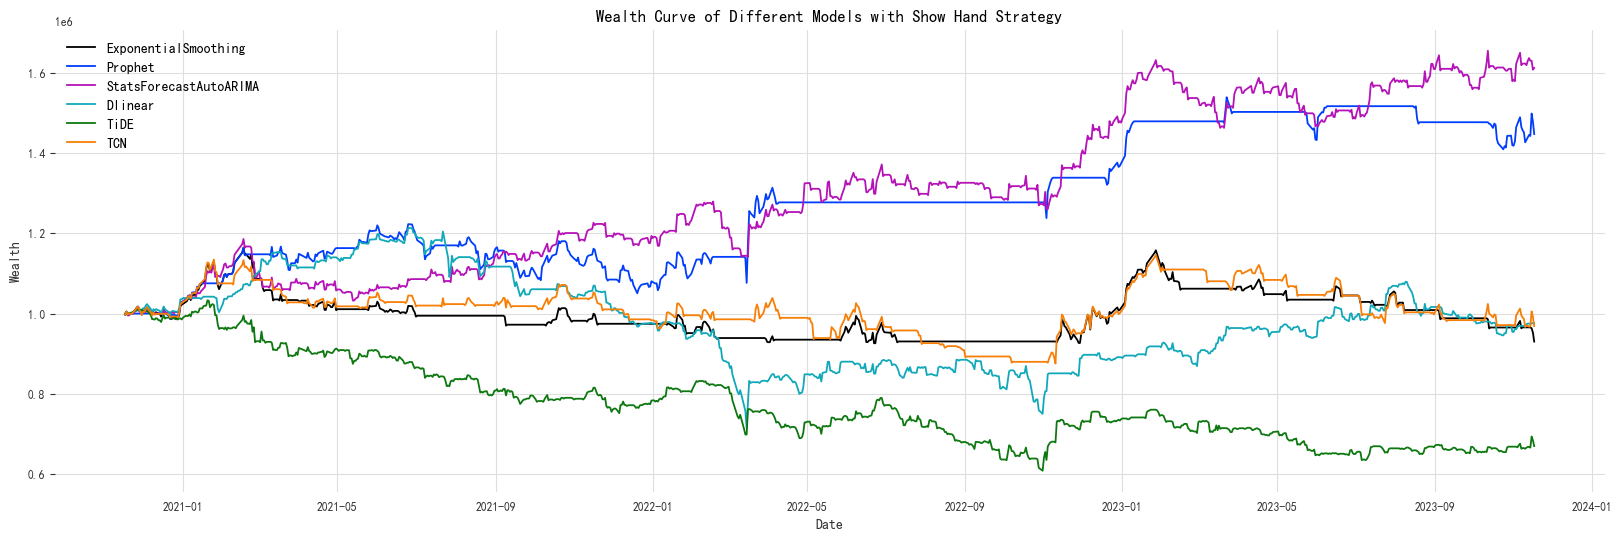

ExponentialSmoothing      的最大回撤为: 20.48%
Prophet                   的最大回撤为: 14.09%
StatsForecastAutoARIMA    的最大回撤为: 12.94%
Dlinear                   的最大回撤为: 41.06%
TiDE                      的最大回撤为: 41.11%
TCN                       的最大回撤为: 22.85%


In [15]:
results_show_hand = []

# 遍历CSV文件的路径列表
for csv_path in csv_paths:
    result = use_csv_to_quant_invest_show_hand(
        series=series,
        duration_start="2020-11-17",
        duration_end="2023-11-17",
        rsi=rsi,
        k=K,
        d=D,
        j=J,
        macd_baseline=macd_baseline,
        interval_num=3,
        csv_path=csv_path,
    )
    results_show_hand.append(result)

plt.figure(figsize=(20, 6))
plt_range = pd.date_range("2020-11-17", "2023-11-17", freq="D")

for i, result in enumerate(results_show_hand):
    plt.plot(plt_range, result[0], label=lables[i])
    print(f"{lables[i]:<25} 的最终收益率为: {result[1]*100:.2f}%")

plt.title("Wealth Curve of Different Models with Show Hand Strategy")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.show()

# 输出最大回撤
for i, result in enumerate(results_show_hand):
    print(f"{lables[i]:<25} 的最大回撤为: {calculate_max_drawdown(result[0]) * 100:.2f}%")

In [16]:
(
    daily_wealth,
    final_return,
    current_stocks,
    daily_rate_of_return,
) = use_csv_to_quant_invest(
    series=series,
    duration_start="2020-11-17",
    duration_end="2023-11-17",
    rsi=rsi,
    k=K,
    d=D,
    j=J,
    macd_baseline=macd_baseline,
    interval_num=3,
    # csv_path="./ExponentialSmoothing_rate_of_return.csv",
    # csv_path="./prophet_rate_of_return.csv",
    # csv_path="./StatsForecastAutoARIMA_rate_of_return.csv",
    # csv_path="./Dlinear_rate_of_return_first.csv",
    # csv_path="./TiDE_rate_of_return.csv",
    # csv_path="./TCN_rate_of_return.csv",
)

C:\Users\12646\AppData\Local\Temp\ipykernel_28724\2585050730.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for day in tqdm.tqdm_notebook(


Quant Investing Progress:   0%|          | 0/1096 [00:00<?, ?it/s]

最终收益率为:  0.2348996635399994


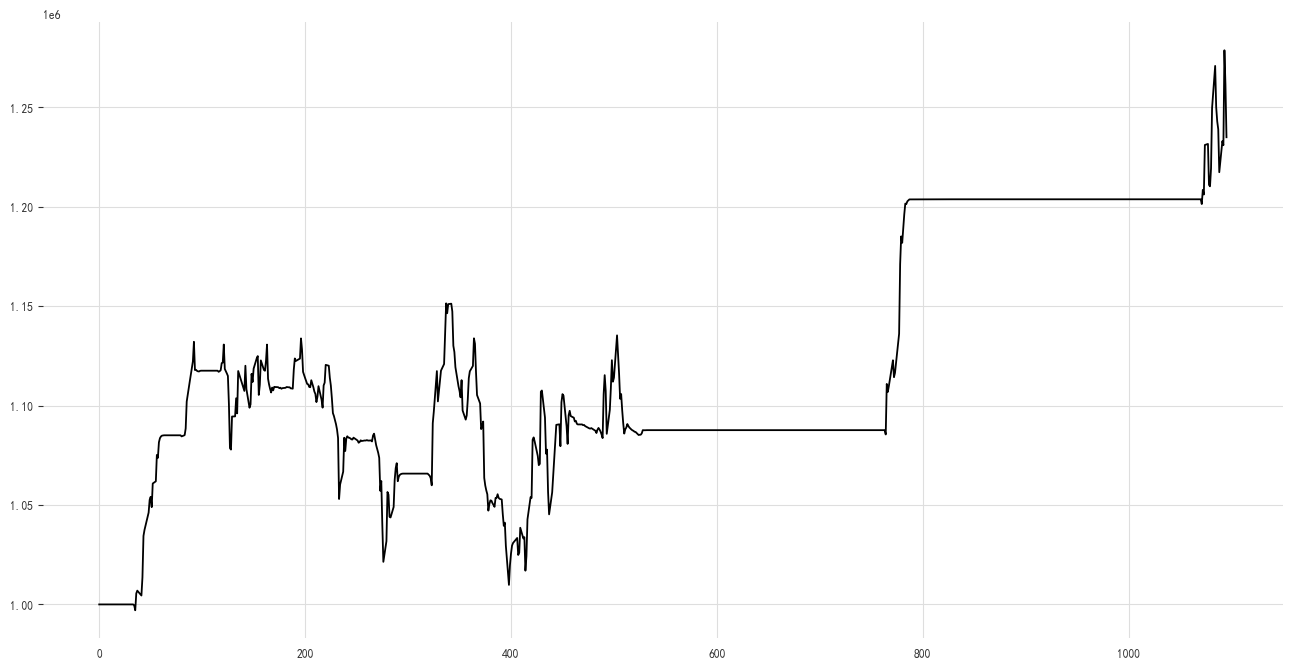

In [17]:
# 拉宽图像
plt.figure(figsize=(16, 8))
plt.plot(daily_wealth, label="Quant Investing")
print("最终收益率为: ", final_return)

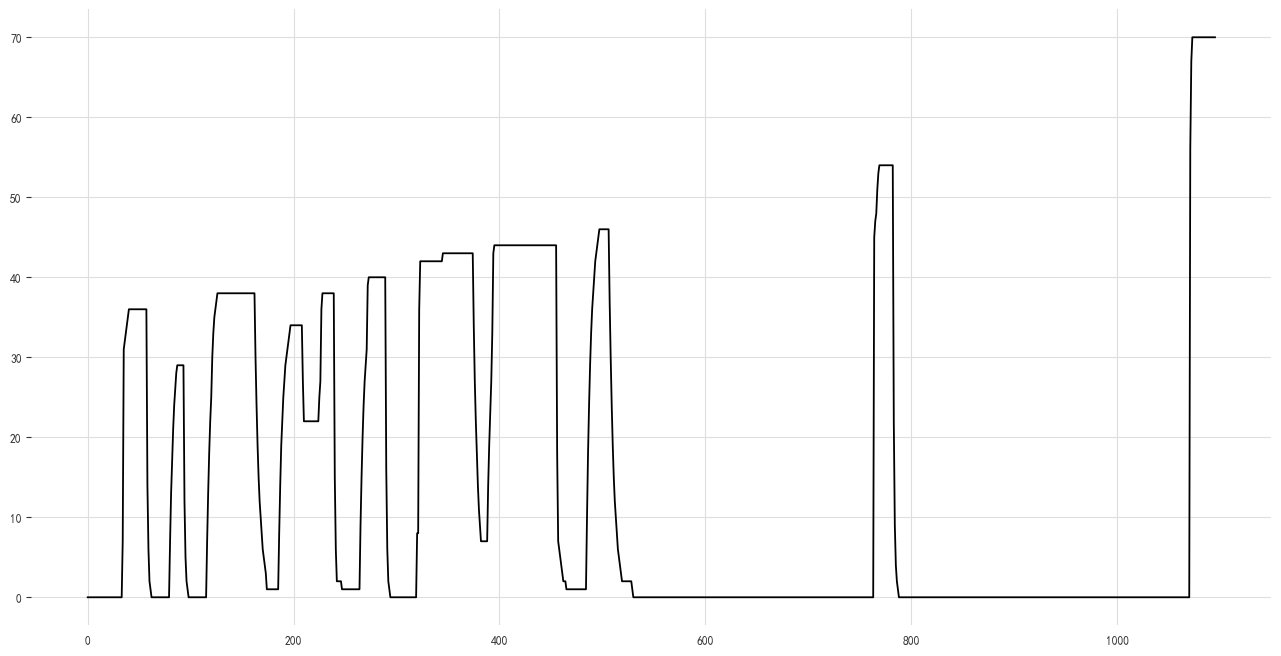

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(current_stocks, label="Current Stocks")

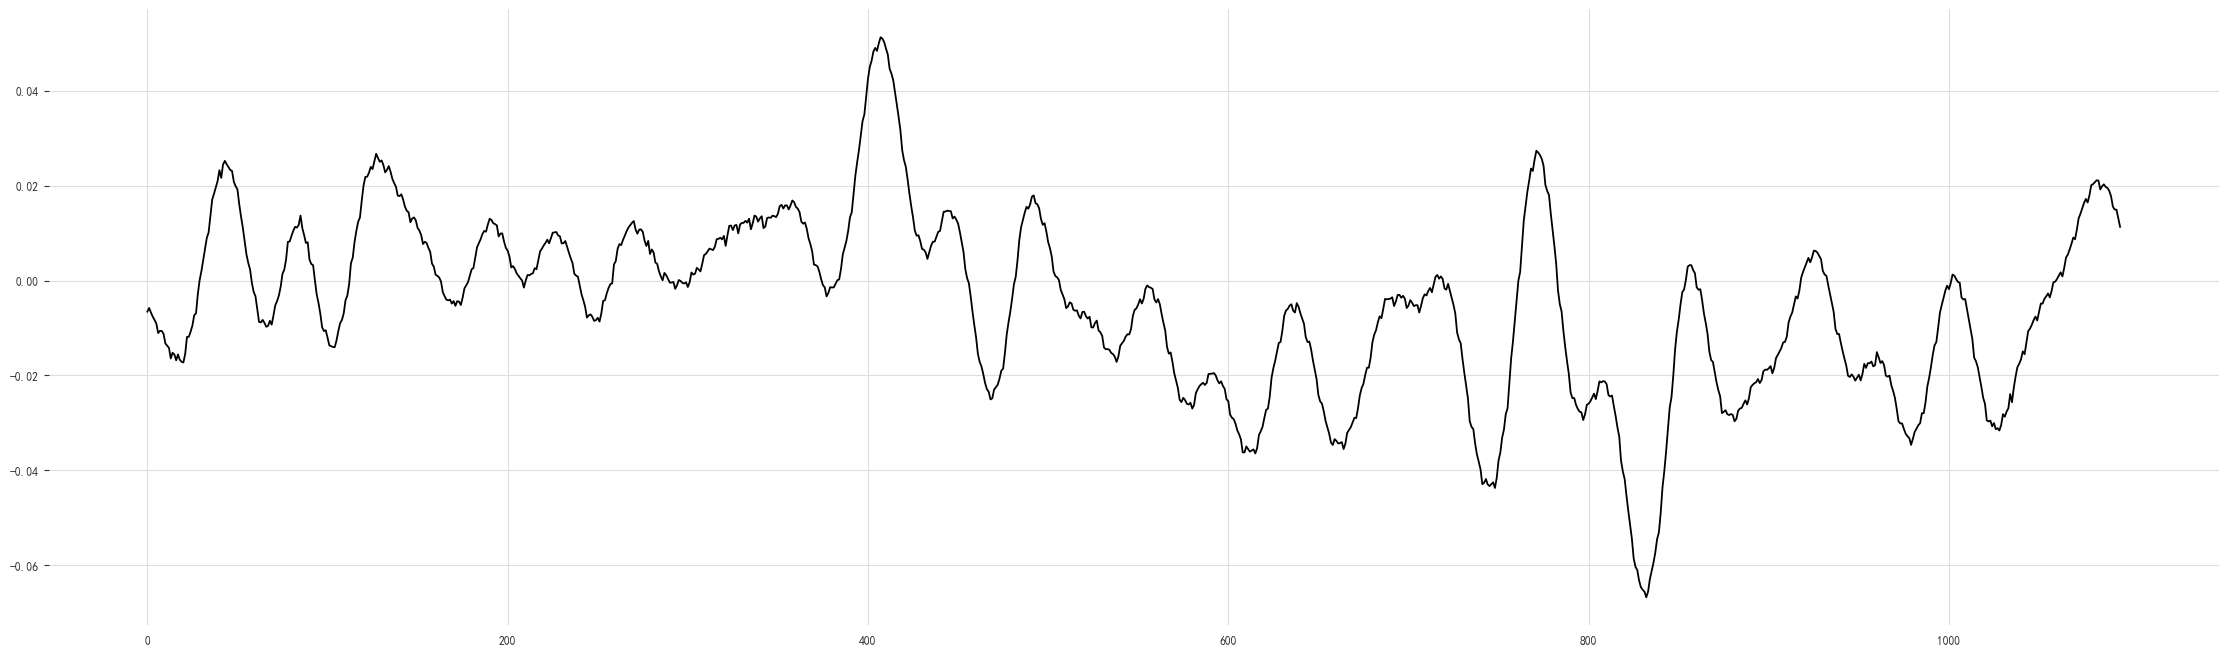

In [19]:
plt.figure(figsize=(28, 8))
plt.plot(daily_rate_of_return, label="Daily Rate of Return")